## Rapid GW Inference with factorized PE framework

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
import sys
# set cogwheel path
sys.path.append('../../cogwheel/') # change if necessary
import glob, time, corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cogwheel
from cogwheel import posterior, utils, data, sampling, gw_plotting
from cogwheel.factorized_qas import IntrinsicParametersPrior, IntrinsicTidalPrior, MarginalizedRelativeBinningLikelihood

### Create a simulated BBH event 

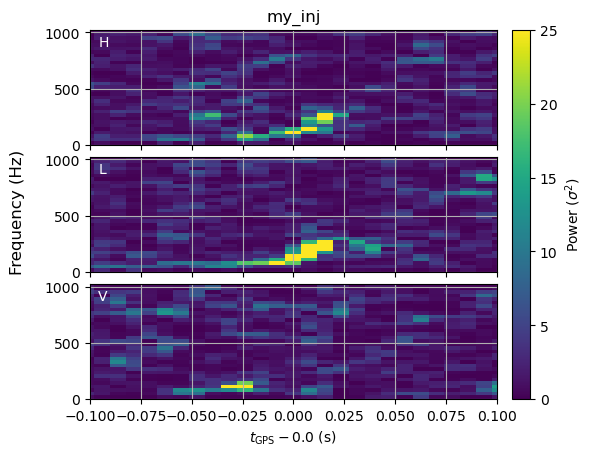

In [2]:
## [ Directory Setup ] ##
parentdir='/home/tousifislam/Documents/works/rapid_pe/runs/'
eventname = 'my_inj'

## [ Create Injection ] ##

# instanciate an GW event with duration, asd functions and detector names
event_data = data.EventData.gaussian_noise(eventname=eventname, duration=8, 
                detector_names='HLV', asd_funcs=['asd_H_O3', 'asd_L_O3', 'asd_V_O3'], tgps=0.0)

# GW signal information
par_dic = {'m1': 33.0,'m2': 33.0,'l1': 0,'l2': 0,
           'd_luminosity': 1000.0,'iota':np.pi/4,'phi_ref':np.pi/5,'ra':2.4, 'dec':0.15, 'psi':0.5,
           's1z': 0.0,'s2z': 0.0,'s1x_n': 0.0,'s1y_n': 0.0,'s2x_n': 0.0,'s2y_n': 0.0,
           't_geocenter': 0.0, 'f_ref': 105.0}

# inject the signal
event_data.inject_signal(par_dic=par_dic, approximant='IMRPhenomXAS')

# plot spectogram
event_data.specgram((-0.1,0.1))

### Parameter Estimation

In [3]:
## [ Likelihood maximization ] ## 
t1=time.time()

# Relaitve binning
post = posterior.Posterior.from_event(event=event_data, 
                                      mchirp_guess=28.8,
                                      approximant='IMRPhenomXAS',
                                      prior_class=IntrinsicParametersPrior, 
                                      likelihood_class=MarginalizedRelativeBinningLikelihood,
                                      prior_kwargs={'d_hat_max': 120, 'symmetrize_lnq': False},
                                      likelihood_kwargs={'nlon': 1000, 'nlat': 1000},
                                      ref_wf_finder_kwargs={'time_range':(-0.1,0.1)})

eventdir = post.get_eventdir(parentdir)
post.to_json(eventdir, overwrite=True)

t2=time.time()
print('*\ntime taken upto finding out max likelihood estimation : %.7f seconds'%(t2-t1))

## [ Sampling ] ##
pym = sampling.PyMultiNest(post)
pym.run_kwargs = {'n_iter_before_update': 1000,'n_live_points': 516,'evidence_tolerance': 0.25}
rundir = pym.get_rundir(parentdir)
print('\nPE rundir : %s'%rundir)
pym.run(rundir)

t2=time.time()
print('*\ntime taken upto sampling : %.7f seconds'%(t2-t1))
print('Done!')

Searching incoherent solution for my_inj
Set intrinsic parameters, lnL = 176.8891127837205
Set time, lnL(L) = 104.81361666765893
Set sky location, lnL = 176.2369003392152
Set phase and distance, lnL = 176.2369003392152
Set mchirp_range = (22.938770730358392, 39.53293111746535)
*
time taken upto finding out max likelihood estimation : 94.3066275 seconds

PE rundir : /home/tousifislam/Documents/works/rapid_pe/runs/IntrinsicParametersPrior/my_inj/run_0
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  516
 dimensionality =    4
 *****************************************************
 ln(ev)=   177.41237896445526      +/-  0.11179413936108042     
 Total Likelihood Evaluations:        10613
 Sampling finished. Exiting MultiNest
*
time taken upto sampling : 188.7666879 seconds
Done!


### Plot posteriors

<Figure size 1000x1400 with 0 Axes>

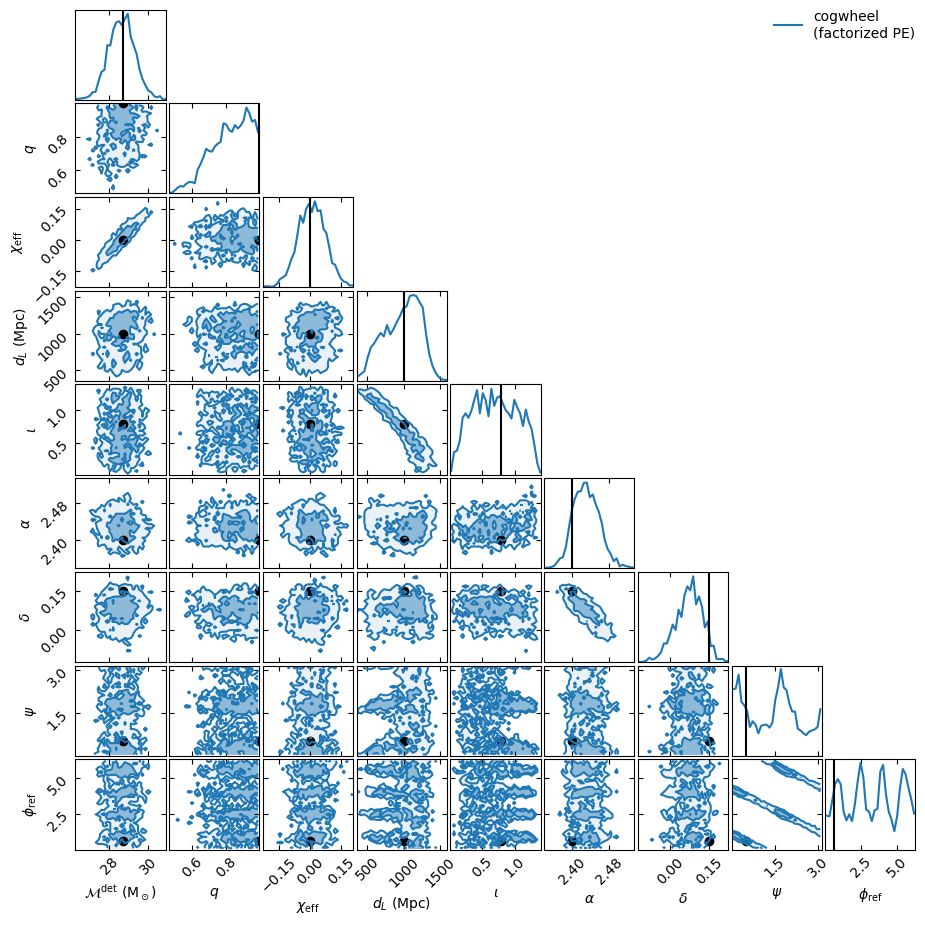

In [5]:
## [ Read samples ] ##
cs_samples = pd.read_feather('%s/samples.feather'%rundir)
cs_samples['q'] = np.exp(-np.abs(cs_samples['lnq']))
cs_samples['psi'] = cs_samples['psi'] % np.pi

## [ Plot ] ##
plt.figure(figsize=(10,14))
cp = gw_plotting.MultiCornerPlot(
     [cs_samples],
     bins=32,
     labels=['cogwheel\n(factorized PE)'],
     params=['mchirp', 'q', 'chieff', 'd_luminosity', 'iota',  'ra', 'dec', 'psi', 'phi_ref'],
     )
cp.plot(tightness=.999, max_n_ticks=3)

par_dic['mchirp'] = 28.72
par_dic['chieff'] = 0.0
par_dic['q'] = par_dic['m2']/par_dic['m1']
cp.scatter_points(par_dic, colors=['k'])